In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
# %pylab inline

In [12]:
qick_path = "/home/xilinx/jupyter_notebooks/alternative_firmware/photon_counting_4/qick_4x2.bit"

bitfile=qick_path

In [13]:
soc = QickSoc(bitfile=qick_path)
soccfg = soc

In [14]:
class AverageSignalProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        
        for ch in cfg['ro_chs']:
            self.declare_readout(ch=ch, length=self.cfg['readout_length'], freq=0, sel='input')
        
        self.synci(200)
    
    def body(self):
        self.trigger(adcs=self.cfg['ro_chs'], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.synci(int(self.cfg['readout_length'] * 1.25))
        self.wait_all(self.cfg['relax_delay'])
        
class PhotonCountingProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        
        for ch in cfg['ro_chs']:

            self.declare_readout(
                ch=ch,
                length=self.cfg['readout_length'],
                freq=0,
                sel='input',
                edge_counting=True,
                high_threshold=3000,
                low_threshold=500)
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=self.cfg['ro_chs'], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.synci(int(self.cfg['readout_length'] * 1.25))
        self.wait_all(self.cfg['relax_delay'])


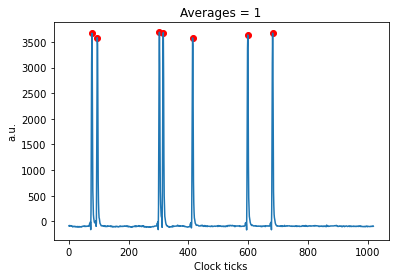

In [15]:
config={"ro_chs":[0], # --Fixed
        "reps": 1,
        "relax_delay":3000, # --us        
        "readout_length":1020, # [Clock ticks]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":1
       }

prog =AverageSignalProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)

data = iq_list[0][0]

# Plot results.
plt.figure(1)
plt.plot(data)
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))

x0, _  = find_peaks(data,height=500)
plt.scatter(x0, data[x0], c='red')

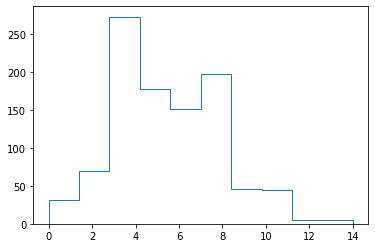

(array([ 32.,  69., 273., 178., 151., 197.,  46.,  44.,   5.,   5.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

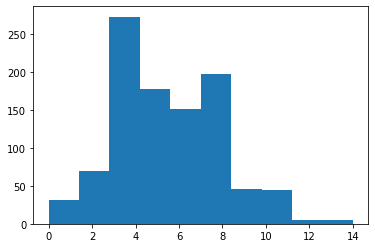

In [16]:
config={"ro_chs":[0], # --Fixed
        "reps": 1,
        "relax_delay":3000, # --us        
        "readout_length":1020, # [Clock ticks]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":1
       }

n = []

for i in range(1000):

    prog =AverageSignalProgram(soccfg, config)
    iq_list = prog.acquire_decimated(soc, progress=False)

    data = iq_list[0][0]
    x0, _  = find_peaks(data,height=500)
    n.append(len(x0))
counts, bins = np.histogram(n)
plt.stairs(counts, bins)
plt.show()
plt.hist(bins[:-1], bins, weights=counts)

[array([[[3, 0]],

       [[4, 0]],

       [[4, 0]],

       ...,

       [[8, 0]],

       [[6, 0]],

       [[6, 0]]])]


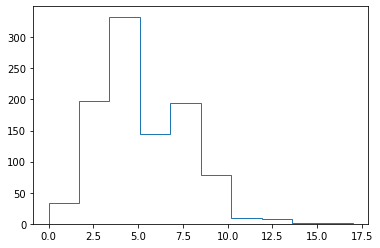

(array([ 34., 197., 333., 144., 194.,  79.,   9.,   8.,   1.,   1.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

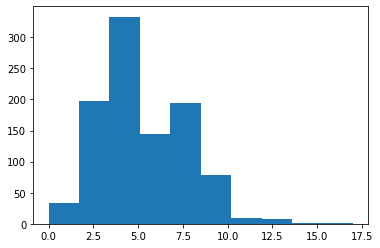

In [17]:
config['reps'] = 1000
config['readout_length'] = 1020
prog = PhotonCountingProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=False)

print(iq_list)
data = np.array([a[0][0] for a in iq_list[0]])

counts, bins = np.histogram(data)
plt.stairs(counts, bins)
plt.show()
plt.hist(bins[:-1], bins, weights=counts)
